In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt
from datetime import datetime
from matplotlib import patches
import geopandas as geop
from matplotlib.lines import Line2D
from math import radians, cos, sin, asin, sqrt
from colour import Color
from scipy.sparse.csgraph import connected_components
from collections import Counter
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mtick
from random import randrange, seed

sns.set_style("whitegrid")

In [3]:
# Sort everyone's name by their last name and print the outcome
# Just a good bit of code to have, honestly 
names = [
    ('Erlang','Surya'),
    ('Maksim','Kosmakov'),
    ('Matt','Mohr'),
    ('Nirdesh','Bhandari'),
    ('Tejaswi','Tripathi')]
for name in sorted(names, key=lambda tup: tup[1]):
    print(name[0],name[1])

Nirdesh Bhandari
Maksim Kosmakov
Matt Mohr
Erlang Surya
Tejaswi Tripathi


In [4]:
# dtype to ensure the csv is interpreted correctly 
dtype = {
    'BEGIN_YEARMONTH': int,
    'BEGIN_DAY': int,
    'BEGIN_TIME': 'Int64',
    'END_YEARMONTH': int,
    'END_DAY': int,
    'END_TIME': int,
    'EPISODE_ID': 'Int64',
    'EVENT_ID': 'Int64',
    'STATE': str,
    'STATE_FIPS': 'Int64',
    'YEAR': 'Int64',
    'MONTH_NAME': str,
    'EVENT_TYPE': str,
    'CZ_TYPE': str,
    'CZ_FIPS': 'Int64',
    'CZ_NAME': str,
    'WFO': str,
    'BEGIN_DATE_TIME': str,
    'CZ_TIMEZONE': str,
    'END_DATE_TIME': str,
    'INJURIES_DIRECT': 'Int64',
    'INJURIES_INDIRECT': 'Int64',
    'DEATHS_DIRECT': 'Int64',
    'DEATHS_INDIRECT': 'Int64',
    'DAMAGE_PROPERTY': str,
    'DAMAGE_CROPS': str,
    'SOURCE': str,
    'MAGNITUDE': 'Float64',
    'MAGNITUDE_TYPE': str,
    'FLOOD_CAUSE': str,
    'TOR_F_SCALE': str,
    'TOR_LENGTH': 'Float64',
    'TOR_WIDTH': 'Float64',
    'TOR_OTHER_WFO': str,
    'TOR_OTHER_CZ_STATE': str,
    'TOR_OTHER_CZ_FIPS': 'Int64',
    'TOR_OTHER_CZ_NAME': str,
    'BEGIN_RANGE': 'Float64',
    'BEGIN_AZIMUTH': str,
    'BEGIN_LOCATION': str,
    'END_RANGE': 'Float64',
    'END_AZIMUTH': str,
    'END_LOCATION': str,
    'BEGIN_LAT': 'Float64',
    'BEGIN_LON': 'Float64',
    'END_LAT': 'Float64',
    'END_LON': 'Float64',
    'EPISODE_NARRATIVE': str,
    'EVENT_NARRATIVE': str,
    'DATA_SOURCE': str,
    'TOR_F_SCALE_MAPPED': 'str',
    'DAMAGE_CROPS_DESUFFIX': 'Float64',
    'DAMAGE_PROPERTY_DESUFFIX': 'Float64'
}

tdf = pd.read_csv('../assets/StormEvents_details_WORKING.csv',dtype=dtype)

# These could be considered EFUs, but without a confirmation that we don't know what they are, we consider them separately 
tdf['TOR_F_SCALE_MAPPED'] = tdf.TOR_F_SCALE_MAPPED.fillna('N/A')

tdf.rename({'Unnamed: 0':'STORM_ID'},axis=1,inplace=True)

# omit any storm without a known starting position because so much of our research requires knowing where things got started
tdf = tdf[(~tdf['BEGIN_LAT'].isna()) & (~tdf['BEGIN_LON'].isna())]

# Many date units so we can we split up this data however we please
tdf['BEGIN_YEAR'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[0:4]))
tdf['BEGIN_DECADE'] = (tdf['BEGIN_YEAR'] // 10) * 10
tdf['BEGIN_LUSTRUM'] = (tdf['BEGIN_YEAR'] // 5) * 5 # https://en.wikipedia.org/wiki/Lustrum
tdf['BEGIN_MONTH'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[-2:]))
tdf['CASUALTIES'] = tdf[['DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','INJURIES_INDIRECT']].sum(axis=1)
tdf['BEGIN_QUARTER'] = tdf['BEGIN_MONTH'] // 4
tdf['BEGIN_YEAR_QUARTER'] = tdf['BEGIN_YEAR'] * 10 + tdf['BEGIN_QUARTER']
tdf['BEGIN_DATE_STR'] = tdf.apply(lambda r : str(r.BEGIN_YEARMONTH) + str(r.BEGIN_DAY),axis=1)
tdf['BEGIN_DATE'] = pd.to_datetime(tdf['BEGIN_DATE_STR'],format='%Y%m%d')
tdf['BEGIN_DAY_OF_YEAR'] = tdf['BEGIN_DATE'].dt.day_of_year         # yeah, i gotcha
tdf['BEGIN_WEEK_OF_YEAR'] = tdf['BEGIN_DATE'].dt.isocalendar().week # ohhhhh
tdf['BEGIN_WEEK_YEAR'] = tdf['BEGIN_YEAR'] + (tdf['BEGIN_WEEK_OF_YEAR']/52)
tdf['BEGIN_MONTH_YEAR'] = tdf['BEGIN_YEAR'] + (tdf['BEGIN_MONTH']/12)
tdf['BEGIN_YEAR_OF_DECADE'] = tdf.apply(lambda r : r.BEGIN_DECADE + int(str(r.BEGIN_YEAR)[-2:])/10 ,axis=1)

# FIPS is a standard for the federal government to identify things counties of states, this combines them into one FK
tdf['FIPS'] = tdf['STATE_FIPS'] * 1000 + tdf['CZ_FIPS']

# We don't need several of the columns from the data source for the assets we generate
rel_cols = [
    'STORM_ID',
    'EPISODE_ID',
    'EVENT_ID',
    'BEGIN_DAY',
    'BEGIN_YEAR',
    'BEGIN_DECADE',
    'BEGIN_YEAR_OF_DECADE',
    'BEGIN_MONTH',
    'BEGIN_QUARTER',
    'BEGIN_YEAR_QUARTER',
    'BEGIN_DATE',
    'BEGIN_DAY_OF_YEAR',
    'BEGIN_WEEK_OF_YEAR',
    'BEGIN_WEEK_YEAR',
    'BEGIN_MONTH_YEAR',
    'BEGIN_LUSTRUM',
    'TOR_F_SCALE_MAPPED',
    'CASUALTIES',]

# Upcase all the columns for consistency jus tin case
tdf.rename({col: col.upper() for col in tdf.columns},axis=1,inplace=True)
tdf = tdf[rel_cols]

# save a copy of the working tdf for spot checking 
tdf.to_csv('current.csv')

# FIG 1 
### All centroid details

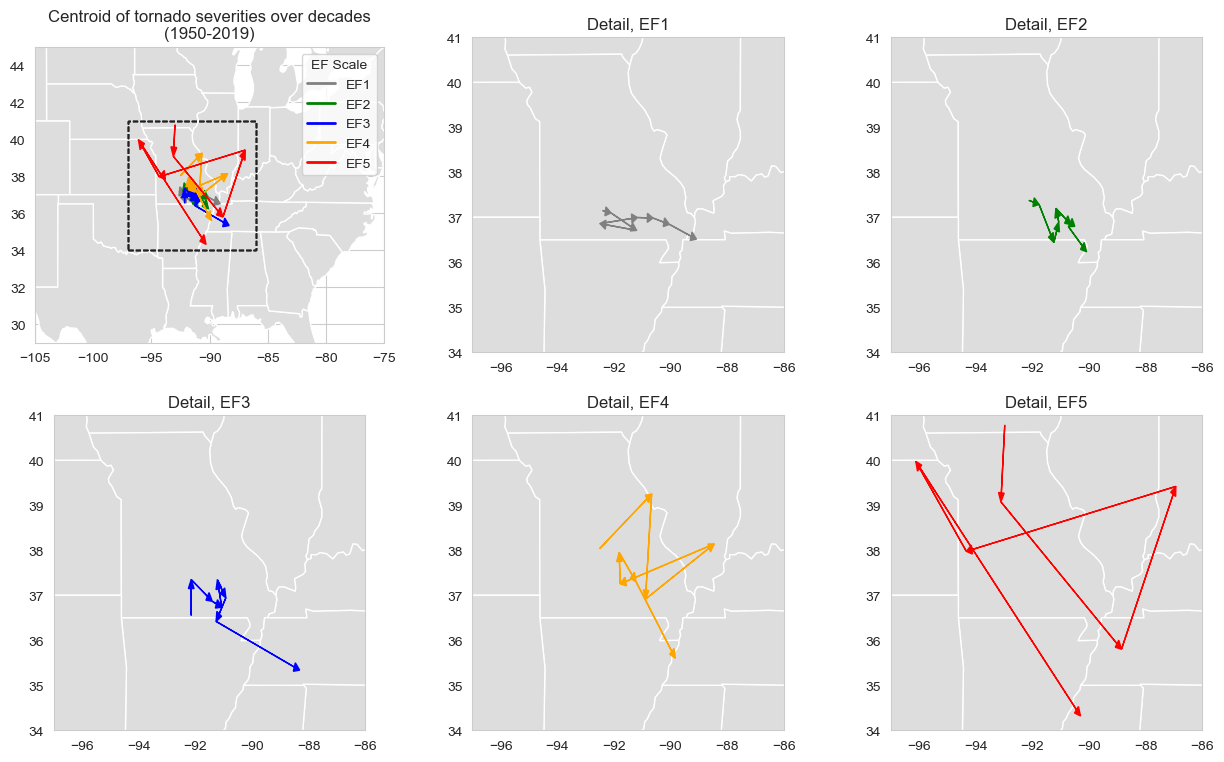

In [99]:
# dict for color consistency 
palette={'EF1':'grey','EF2':'green','EF3':'blue','EF4':'orange','EF5':'red'}

time_unit = 'BEGIN_DECADE'

# contains a map of the US and Canda for mapping 
usa_canada_map_data = geop.read_file('../assets/combined-us-canada-with-states-provinces_793.geojson')
rows_, cols_ = 2, 3
fig, axs = plt.subplots(rows_,cols_,figsize=(15.3,9))

for row, sub_axs in enumerate(axs):
    for col, ax in enumerate(sub_axs):
        usa_canada_map_data.plot(ax=ax,color='#DDD')
        head_dim = .2 # used in arrow construction 
        if row + col == 0: # when building the first graph, consider every EF instead of plotting just 1
            keys = palette.keys()
            legend_elements = [Line2D([0], [0], color=color, lw=2, label=ef) for ef, color in palette.items()]
            ax.legend(handles=legend_elements, title='EF Scale')
            detail = patches.Rectangle((-97,34),11,7,linestyle='--',edgecolor='#222',facecolor='none')
            head_dim=.5
        else:
            keys = [list(palette.keys())[row*cols_ + col -1]]
        for ef in keys:    
            # Identify the mean LAT and LON of each tornado based on the previous identify time_unit column 
            arrows = tdf[tdf['TOR_F_SCALE_MAPPED'] == ef][[time_unit,'BEGIN_LAT','BEGIN_LON']].groupby([time_unit]).mean().reset_index()
            
            for idx in range(len(arrows)):
                if idx > 0:
                    # Draw an arrow from [idx -1] to idx so we can trace the path of the centroid of all tornadoes 
                    arw = patches.FancyArrow(
                                arrows.iloc[idx - 1].BEGIN_LON,
                                arrows.iloc[idx - 1].BEGIN_LAT,
                                arrows.iloc[idx].BEGIN_LON - arrows.iloc[idx-1].BEGIN_LON,
                                arrows.iloc[idx].BEGIN_LAT - arrows.iloc[idx-1].BEGIN_LAT,
                                color=palette[ef],
                                length_includes_head = True,
                                head_length=head_dim,
                                head_width=head_dim,
                                label=arrows.iloc[idx][time_unit]
                            )
                    ax.add_patch(arw)

            # axes consistency and UI stuff         
            ax.set_ylim(34,41)
            ax.set_xlim(-97,-86)
            ax.set_title('Detail, ' + ef)
            if row + col == 0:
                ax.add_patch(detail)
                ax.set_ylim(29,45)
                ax.set_xlim(-105,-75)
                ax.set_title('Centroid of tornado severities over decades\n(1950-2019)')

plt.show()


# FIG 2
### Centroid of all EFs on one 

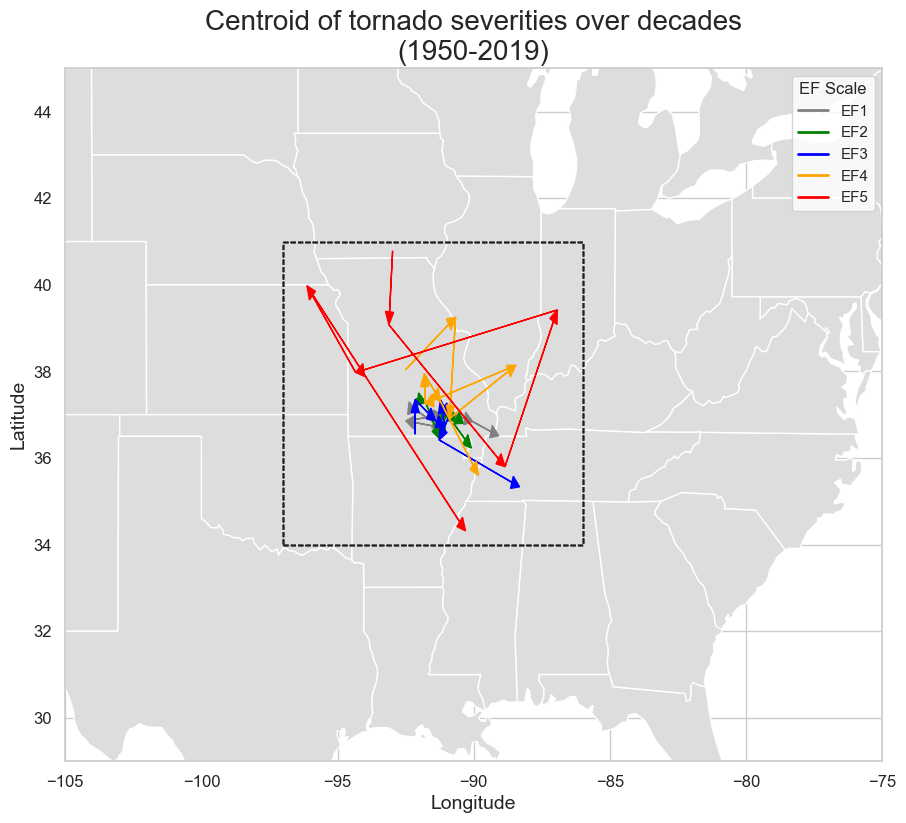

In [212]:
# this is just FIG1 but with the entire fig filled by the zoomed out map 
palette={'EF1':'grey','EF2':'green','EF3':'blue','EF4':'orange','EF5':'red'}
time_unit = 'BEGIN_DECADE'

usa_canada_map_data = geop.read_file('../assets/combined-us-canada-with-states-provinces_793.geojson')
rows_, cols_ = 1, 1
fig, axs = plt.subplots(rows_,cols_,figsize=(12,9))

for row, sub_axs in enumerate([axs]):
    for col, ax in enumerate([sub_axs]):
        usa_canada_map_data.plot(ax=ax,color='#DDD')
        head_dim = .2
        if row + col == 0:
            keys = palette.keys()
            legend_elements = [Line2D([0], [0], color=color, lw=2, label=ef) for ef, color in palette.items()]
            ax.legend(handles=legend_elements, title='EF Scale')
            detail = patches.Rectangle((-97,34),11,7,linestyle='--',edgecolor='#222',facecolor='none')
            head_dim=.3
        for ef in keys:    
            arrows = tdf[tdf['TOR_F_SCALE_MAPPED'] == ef][[time_unit,'BEGIN_LAT','BEGIN_LON']].groupby([time_unit]).mean().reset_index()
            for idx in range(len(arrows)):
                if idx > 0:
                    arw = patches.FancyArrow(
                                arrows.iloc[idx - 1].BEGIN_LON,
                                arrows.iloc[idx - 1].BEGIN_LAT,
                                arrows.iloc[idx].BEGIN_LON - arrows.iloc[idx-1].BEGIN_LON,
                                arrows.iloc[idx].BEGIN_LAT - arrows.iloc[idx-1].BEGIN_LAT,
                                color=palette[ef],
                                length_includes_head = True,
                                head_length=head_dim,
                                head_width=head_dim,
                                label=arrows.iloc[idx][time_unit]
                            )
                    
                    ax.add_patch(arw)

            if row + col == 0:
                ax.add_patch(detail)
                ax.set_ylim(29,45)
                ax.tick_params(axis='both', which='major', labelsize=12) 
                ax.set_ylabel('Latitude',fontsize=14)
                ax.set_xlabel('Longitude',fontsize=14)
                
                ax.set_xlim(-105,-75)
                ax.set_title('Centroid of tornado severities over decades\n(1950-2019)',fontsize=20)
    
plt.show()


# FIG 3
### Centroid of all tornadoes 

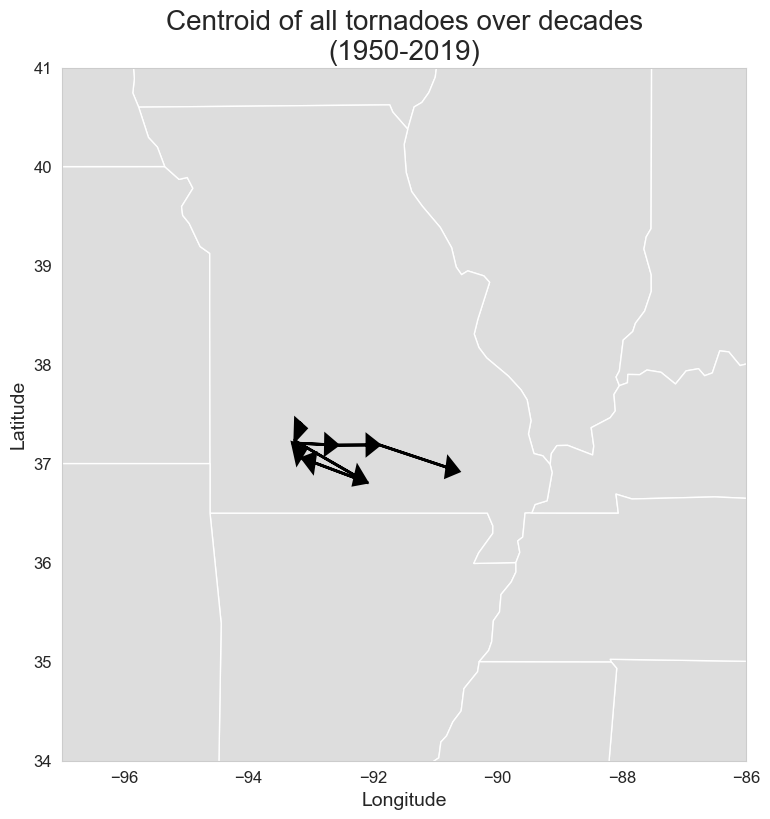

ESE at 6.7 km, 4.2 miles per year


In [111]:
palette={'EF1':'grey','EF2':'green','EF3':'blue','EF4':'orange','EF5':'red'}
time_unit = 'BEGIN_DECADE'

usa_canada_map_data = geop.read_file('../assets/combined-us-canada-with-states-provinces_793.geojson')
rows_, cols_ = 1, 1
fig, axs = plt.subplots(rows_,cols_,figsize=(12,9))

mean_lat, mean_lon = [],[]

# this is adopted from Fig 2, but reduced to show all EFs on one graph
# there is, of course, a more efficient way of doing this. But with 9 days to work with, you either get 'effecient' or 'working.' 
# we settled on 'working.'
for row, sub_axs in enumerate([axs]):
    for col, ax in enumerate([sub_axs]):
        usa_canada_map_data.plot(ax=ax,color='#DDD')
        head_dim = .2
        if row + col == 0:
            keys = palette.keys()
            legend_elements = [Line2D([0], [0], color=color, lw=2, label=ef) for ef, color in palette.items()]
            head_dim=.2

        arrows = tdf[[time_unit,'BEGIN_LAT','BEGIN_LON']].groupby([time_unit]).mean().reset_index()
        mean_lat = arrows['BEGIN_LAT']
        mean_lon = arrows['BEGIN_LON']
        for idx in range(len(arrows)):
            if idx > 0:
                arw = patches.FancyArrow(
                            arrows.iloc[idx - 1].BEGIN_LON,
                            arrows.iloc[idx - 1].BEGIN_LAT,
                            arrows.iloc[idx].BEGIN_LON - arrows.iloc[idx-1].BEGIN_LON,
                            arrows.iloc[idx].BEGIN_LAT - arrows.iloc[idx-1].BEGIN_LAT,
                            color='black',
                            length_includes_head = True,
                            linewidth=2,
                            head_length=head_dim,
                            head_width=head_dim,
                            label=arrows.iloc[idx][time_unit]
                        )
                
                ax.add_patch(arw)

        #ax.add_patch(detail)
        ax.set_ylim(29,45)
        ax.tick_params(axis='both', which='major', labelsize=12) 
        ax.set_ylabel('Latitude',fontsize=14)
        ax.set_xlabel('Longitude',fontsize=14)
        
        ax.set_xlim(-105,-75)
        ax.set_title('Centroid of all tornadoes over decades\n(1950-2019)',fontsize=20)
        ax.set_ylim(34,41)
        ax.set_xlim(-97,-86)
    
plt.show()
distances = []
# Quickly calculate the mean translation distance of the centroid 
for idx, coords in enumerate(zip(mean_lat,mean_lon)):
    if idx > 0:
        lat, lon = coords[0], coords[1]
        lat1=radians(last_lat)
        lat2=radians(lat)
        dlat=lat1-lat2
        dlon=radians(last_lon - lon)
        distances.append(2*6367*asin(sqrt(sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2))//1)
    last_lat, last_lon = coords[0], coords[1]

print(f"ESE at {round(np.mean(distances),0)/10} km, {round(np.mean(distances)*0.621371,0)/10} miles per year")


# FIG 4
### Casualty Centroid (OMITTED)

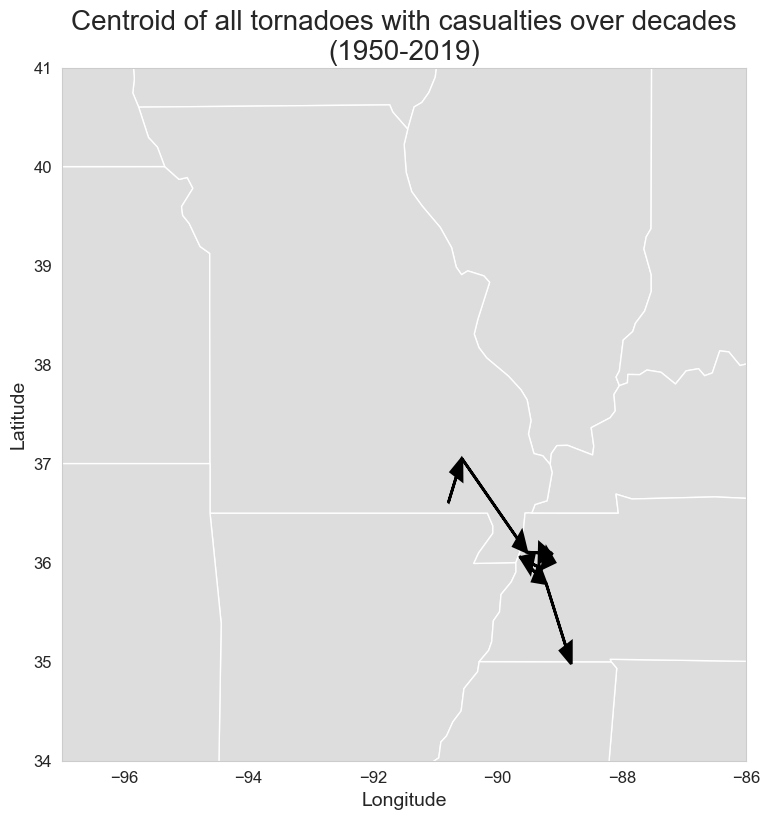

In [112]:
# Same idea as the last few, but this one just captures the centroid of tornadoes that actually cause casualties. 
# This is moving South much faster, but it's hard to figure out why casualty storms are doing this in particular, so we left it out
# We aren't experts so saying "Deadly storms are moving into Mississippi" is a bad look

palette={'EF1':'grey','EF2':'green','EF3':'blue','EF4':'orange','EF5':'red'}
time_unit = 'BEGIN_DECADE'

usa_canada_map_data = geop.read_file('../assets/combined-us-canada-with-states-provinces_793.geojson')
rows_, cols_ = 1, 1
fig, axs = plt.subplots(rows_,cols_,figsize=(12,9))

for row, sub_axs in enumerate([axs]):
    for col, ax in enumerate([sub_axs]):
        usa_canada_map_data.plot(ax=ax,color='#DDD')
        head_dim = .2
        if row + col == 0:
            keys = palette.keys()
            legend_elements = [Line2D([0], [0], color=color, lw=2, label=ef) for ef, color in palette.items()]
            #ax.legend(handles=legend_elements, title='EF Scale')
            #detail = patches.Rectangle((-97,34),11,7,linestyle='--',edgecolor='#222',facecolor='none')
            head_dim=.2
          
        arrows = tdf[tdf['CASUALTIES'] > 0][[time_unit,'BEGIN_LAT','BEGIN_LON']].groupby([time_unit]).mean().reset_index()
        for idx in range(len(arrows)):
            if idx > 0:
                arw = patches.FancyArrow(
                            arrows.iloc[idx - 1].BEGIN_LON,
                            arrows.iloc[idx - 1].BEGIN_LAT,
                            arrows.iloc[idx].BEGIN_LON - arrows.iloc[idx-1].BEGIN_LON,
                            arrows.iloc[idx].BEGIN_LAT - arrows.iloc[idx-1].BEGIN_LAT,
                            color='black',
                            length_includes_head = True,
                            linewidth=2,
                            head_length=head_dim,
                            head_width=head_dim,
                            label=arrows.iloc[idx][time_unit]
                        )
                
                ax.add_patch(arw)
        
        #ax.add_patch(detail)
        ax.set_ylim(29,45)
        ax.tick_params(axis='both', which='major', labelsize=12) 
        ax.set_ylabel('Latitude',fontsize=14)
        ax.set_xlabel('Longitude',fontsize=14)
        
        ax.set_xlim(-105,-75)
        ax.set_title('Centroid of all tornadoes with casualties over decades\n(1950-2019)',fontsize=20)
        ax.set_ylim(34,41)
        ax.set_xlim(-97,-86)

plt.show()


# FIG 5
### 100% Stacked share of tornado intensity

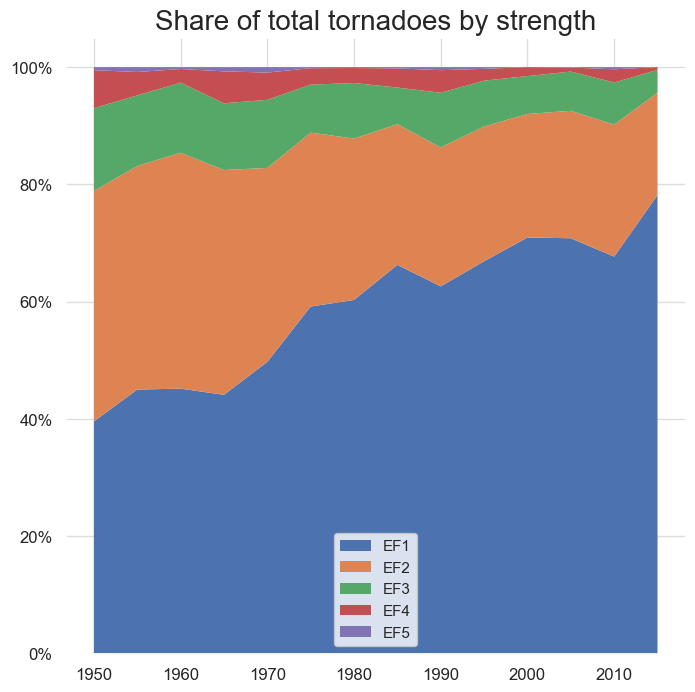

In [239]:
# This will show a stacked chart of the share of each intensity of tornado such that they add up to 100%
# The idea is to show the growth and decline of certain types over time in an attractive and simple way

palette={'EF1':'grey','EF2':'green','EF3':'blue','EF4':'orange','EF5':'red'}

#date_unit, date_counts = 'BEGIN_YEAR', 1
date_unit, date_counts = 'BEGIN_LUSTRUM', 5
#date_unit, date_counts = 'BEGIN_DECADE', 10

date_range = tdf[date_unit].unique()[:-1] # exclude the most recent date chunk because anything more than 1 year should exclude anything after 2020

rel_col = [date_unit,'EVENT_ID','CASUALTIES','TOR_F_SCALE_MAPPED']

count= {}

for idx, yr in enumerate(date_range):
    count[yr] = {}
    for ef in palette.keys():
        mask = (tdf['TOR_F_SCALE_MAPPED'] == ef) & (tdf[date_unit] == yr) 
        masked_data = tdf[mask][rel_col]
        count[yr][ef] = masked_data['CASUALTIES'].count() / date_counts

count_pd = pd.DataFrame(count).fillna(0).T

count_pd['tots'] = [row.EF1 + row.EF2 + row.EF3 + row.EF4 + row.EF5 for row in count_pd.itertuples()]

for n in range(1,6):
    count_pd['ratio_EF'+str(n)] = count_pd['EF'+str(n)] / count_pd['tots'] *100

count_ratio_out = [count_pd[col].values for col in count_pd.columns[6:11]]

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.stackplot(
    date_range,
    count_ratio_out,
    labels=['EF1','EF2','EF3','EF4','EF5'],
    edgecolor='none'
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_title('Share of total tornadoes by strength',fontsize=20)
ax.legend(loc=8)
ax.tick_params(axis='both', which='major', labelsize=12) 
plt.show()
fig.savefig('../assets/ef_share.png')

# FIG 6 
### 40KM Cluster per year and LR 

In [118]:
#Some global parameters:
#Minimum number of tornados in each cluster
numt=2

#Radius of the tornadoes for F1 and higher and for F2 and higher (in km):
radF1=40

F1_plus={'EF1','EF2','EF3','EF4','EF5','F1','F2','F3','F4','F5'}
F2_plus=F1_plus-{"EF1",'F1'}
F3_plus=F2_plus-{'EF2','F2'}
F4_plus=F3_plus-{'EF3','F3'}
F5=F4_plus-{'EF4','F4'}

#Define a function that takes a tornado data , sort them by the date, checks if the torandoes appear in the prescribed radius and are of the same type
# and returns only those that form a  cluster 

def clust(data,type,radius):
    #Create outcome Dataframe 
    clusters=pd.DataFrame()
    
    # First sort  by the same date and delete those groups that have < numt torandoes 

    gr=data.groupby(["BEGIN_YEARMONTH","BEGIN_DAY"]).groups
    for k,v in gr.copy():
       if len(gr[k,v]) <numt:
          del gr[k,v]


    for y,d in gr:
# Form a group of the tornadoes that happen in the same day 
        mini=data.loc[gr[y,d]]
            
    
    # Introduce the adjacency matrix and  some distances 
    
        
        adj=np.zeros((len(mini),len(mini)))
        dist1=np.zeros((len(mini),len(mini)))
        ind=[]
        for  i in range(len(mini)):
          for k in range(i+1,len(mini)):
    # converting lat and lon distnces in km 
               lat1=radians(mini['BEGIN_LAT'].iloc[i])
               lat2=radians(mini['BEGIN_LAT'].iloc[k])
               dlat=lat1-lat2
               dlon=radians(mini['BEGIN_LON'].iloc[i]-mini['BEGIN_LON'].iloc[k])
                
    # calculating distnce using  lat, lon and converting to  km
    # https://www.geeksforgeeks.org/program-distance-two-points-earth/
            
               distance = 2*6367*asin(sqrt(sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2))//1
              
    
    #form a matrix of 0 and 1 with rows and columns are tornadoes from the group
    #with i,j entry = 1   if torando i and tornado j happen within the prescribed radius  and if they are in F1_plus group  :
               if  (distance< radius) and (mini['TOR_F_SCALE'].iloc[i] in type) and (mini['TOR_F_SCALE'].iloc[k] in type)  :
                 adj[i,k]=1
    
        
    # find the conneced components of the graph with adjacency matrix = adj    =    finding which tornadoes form a cluster  
        con_comp=connected_components(adj)
        
    
        
    #create a "cluster" group column 
        mini['cluster'] = np.nan
        for a,b in enumerate(con_comp[1]):
            mini.iloc[a,-1]=b*0.00001 # mini['BEGIN_EARMONTH'].iloc[a]*100+b*0.0001
        
    
# consider only clusters that  have more then numt tornadoes inside 
        new_cluster=mini[mini.groupby('cluster')['cluster'].transform('size') >= numt]
        new_cluster.iloc[:,-1]=new_cluster.iloc[:,-1] +y*100+d
 
        clusters = pd.concat([clusters, new_cluster], ignore_index = False)


    return clusters

# some statistics 

def mean_LatLon(cluster,year_beg,year_end):
    df=pd.DataFrame(columns = ['Year','Mean_LAT', 'Mean_LON','Tot_tornadoes','Tot_casualties'])
    for  y in range(year_beg,year_end+1):  
       Num_Tot=len(cluster.loc[cluster['cluster']//10000  ==y ])
       Mean_LAT= cluster.loc[cluster['cluster']//10000  ==y ,'BEGIN_LAT'].mean()
       Mean_LON=cluster.loc[cluster['cluster']//10000  ==y ,'BEGIN_LON'].mean()
       Tot_cas=cluster.loc[cluster['cluster']//10000  ==y, 'casualties' ].sum()

       
       df.loc[-1] = [y, Mean_LAT, Mean_LON,Num_Tot, Tot_cas]
       df.index=df.index+1
    return  df.sort_values(by=['Year'])


def typestat(year, Clust_F1, print_data=False):
    num_ofF1=0
    num_ofF2=0
    num_ofF3=0
    num_ofF4=0
    num_ofF5=0
    Num_tot=0
    for c in set(Clust_F1['cluster'].values):
        x=Counter(Clust_F1.loc[Clust_F1['cluster'].values==c,'TOR_F_SCALE'].values)
        
        if c//10000==year:
            Num_tot+=1
            num_ofF1=num_ofF1+x['F1']+x['EF1']
            num_ofF2=num_ofF2+x['F2']+x['EF2']
            num_ofF3=num_ofF3+x['F3']+x['EF3']
            num_ofF4=num_ofF4+x['F4']+x['EF4']
            num_ofF5=num_ofF5+x['F5']+x['EF5']
        
    if print_data:
       print('In', year,'Number of clusters with F1= ',num_ofF1,'Number of   clusters with F2= ',num_ofF2,'Number of   clusters with F3 = ',
          num_ofF3,'Number of   clusters  with F4= ',num_ofF4,'Number of  clusters with F5',num_ofF5,' Total clusters= ', Num_tot )
    return  [num_ofF1,num_ofF2,num_ofF3,num_ofF4,num_ofF5,Num_tot]

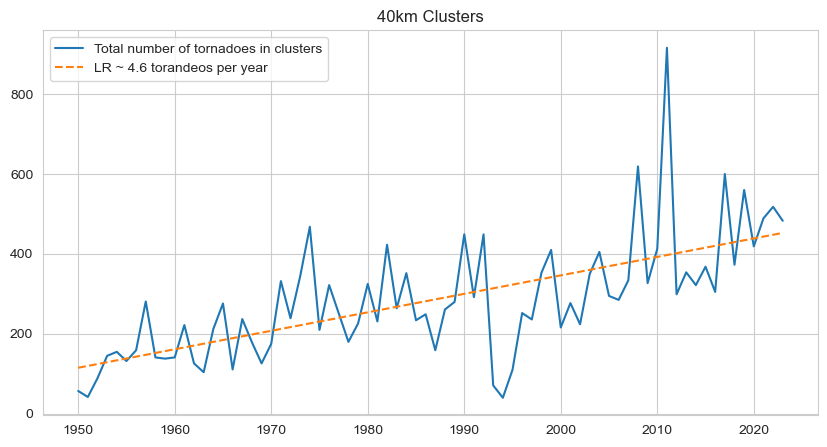

In [119]:

#Import data
data_file= pd.read_csv('../assets/StormEvents_details_WORKING.csv')

# adding casualties and datetime

#Building clusters from the data
Clust_F1=clust(data_file,F1_plus,radF1)

data_file['casualties']=data_file['INJURIES_DIRECT']+data_file['INJURIES_INDIRECT']+data_file['DEATHS_DIRECT']+data_file['DEATHS_INDIRECT']
Clust_F1['casualties']=Clust_F1['INJURIES_DIRECT']+Clust_F1['INJURIES_INDIRECT']+Clust_F1['DEATHS_DIRECT']+Clust_F1['DEATHS_INDIRECT']

BEGIN_DATE = []
  
for i in Clust_F1.index:
    y=Clust_F1["BEGIN_YEARMONTH"][i]//100
    m=Clust_F1["BEGIN_YEARMONTH"][i]%100
    BEGIN_DATE.append(pd.to_datetime(str(y)+'-'+str(m)+'-'+str(Clust_F1["BEGIN_DAY"][i])))

    
Clust_F1.insert(1, "BEGIN_DATE", BEGIN_DATE, True)

MeanF1=mean_LatLon(Clust_F1,1950,2023)

skl=LinearRegression()
skl_Torbyyear=skl.fit(MeanF1['Year'].values.reshape(-1,1),MeanF1['Tot_tornadoes'])

plt.figure(figsize=(10, 5))
plt.plot(MeanF1['Year'],MeanF1['Tot_tornadoes'], label='Total number of tornadoes in clusters')
plt.plot(MeanF1['Year'],skl.predict(MeanF1['Year'].values.reshape(-1,1)), label='LR ~ 4.6 torandeos per year',linestyle='--')
plt.legend()
plt.title('40km Clusters')
plt.savefig('../assets/Total number of tornadoes.png',bbox_inches='tight')
plt.show()

# FIG 7
### Share of all tornado intensity clusters comapred to all others

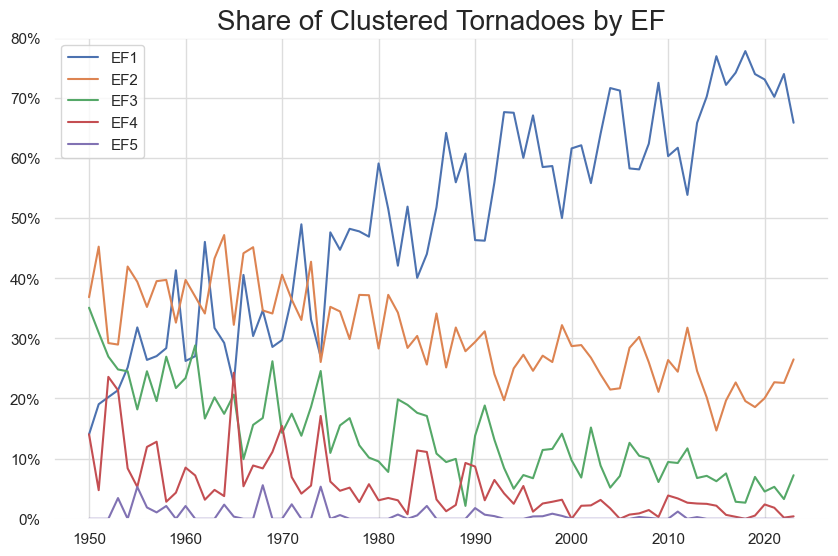

In [221]:
Type_data=pd.DataFrame(columns=["Year",'num_ofF1','num_ofF2','num_ofF3','num_ofF4','num_ofF5','Tot_num_of_cluster'])

for i in range(1950,2024):
     new_row=[i]+typestat(i, Clust_F1=Clust_F1)
     Type_data.loc[-1] = new_row # adding a row
     Type_data.index = Type_data.index + 1  # shifting index
Type_data = Type_data.sort_values(by=['Year'])

fig, ax = plt.subplots(1,1,figsize=(10,6.25))

efs = ['num_ofF' + str(x) for x in range(1,6)]

for ef in efs:
    ax.plot(np.arange(1950,2024),(Type_data[ef]/MeanF1['Tot_tornadoes']*100),label='E' +ef[-2:])
   
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim(0,80)
ax.set_title('Share of Clustered Tornadoes by EF',fontsize=20)
plt.legend()
plt.show()

# Save the full figure...
fig.savefig('../assets/cluster_share.png')

# FIG 8
### The mean casualties (Deaths and Injuries directly and indirectly due to tornadoes) per tornado of each intensity and total casualites they have caused 

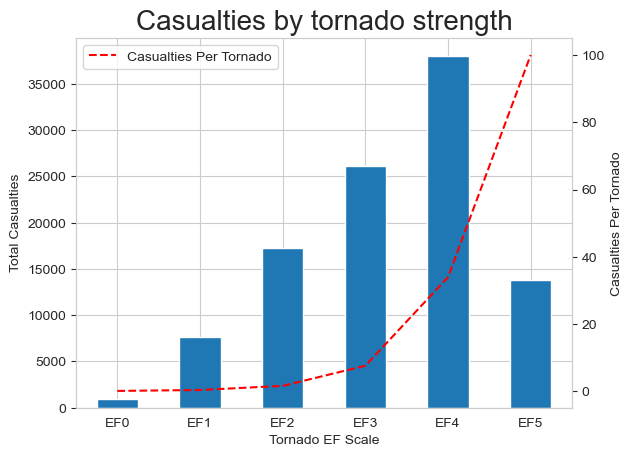

In [117]:
df_plot= tdf[(tdf['BEGIN_YEAR'] >= 1950) & tdf['TOR_F_SCALE_MAPPED'].isin(['EF1','EF2','EF3','EF4','EF5','EF0'])].groupby(['TOR_F_SCALE_MAPPED'], as_index=False )['CASUALTIES'].agg(['sum','count'])
df_plot['Casualties_Per_Tornado'] = df_plot['sum'] / df_plot['count']
df_plot = df_plot[df_plot.TOR_F_SCALE_MAPPED != 'EFU']
df_plot.plot(x='TOR_F_SCALE_MAPPED', y = 'sum', kind = 'bar' , legend = False,xlabel = 'Tornado EF Scale', ylabel = 'Total Casualties')
df_plot['Casualties_Per_Tornado'].plot(secondary_y=True,c= 'red', ylabel = 'Casualties Per Tornado', linestyle='--' )
plt.legend(["Casualties Per Tornado"])
plt.title('Casualties by tornado strength',fontsize=20)
plt.show()

# FIG 9
### Not actually scientific or insightful, just a neat way to visualize all tornadoes as a big spiral through time

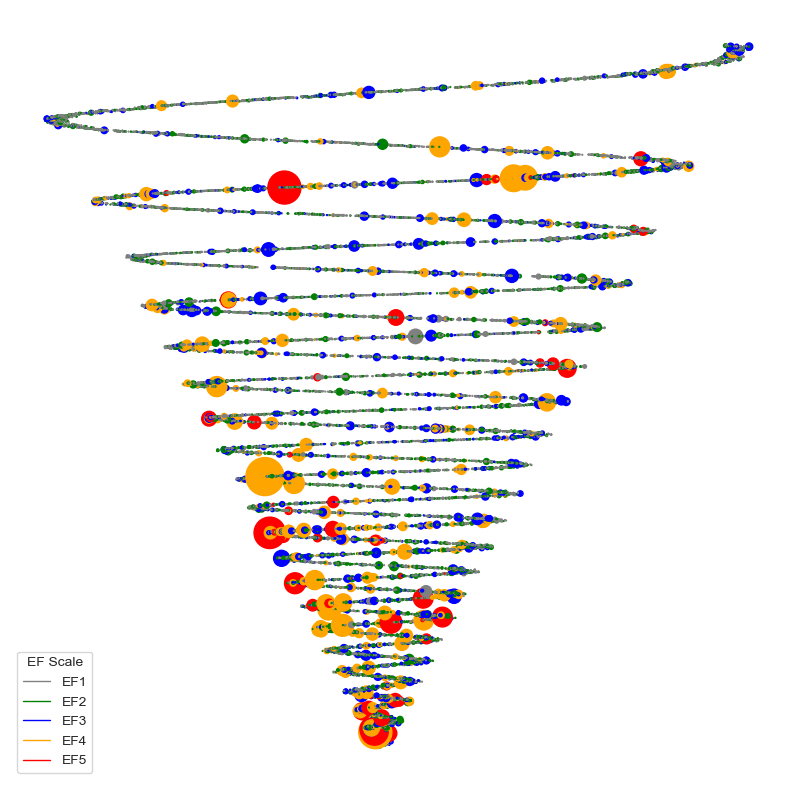

In [98]:
palette={'EF1':'grey','EF2':'green','EF3':'blue','EF4':'orange','EF5':'red'}
tdf['CASUALTIES_NORM'] = tdf['CASUALTIES']/tdf['CASUALTIES'].max()
tdf['CASUALTIES_NORM'].replace(to_replace=0,value = 0.0005, inplace=True)
tdf['CASUALTIES_NORM'] *= 5
cyclone_df = tdf[tdf['TOR_F_SCALE_MAPPED'].isin(list(palette.keys()))][['CASUALTIES_NORM','TOR_F_SCALE_MAPPED','BEGIN_YEAR','BEGIN_MONTH']].sort_values(['BEGIN_YEAR','BEGIN_MONTH'])
cyclone_df['BEGIN_MONTH_RAT'] = cyclone_df['BEGIN_MONTH'] / 12
cyclone_df

# Generate x values
x = np.linspace(0, 75, len(cyclone_df))

seed(615)

wavelength_mod = -.006125 # higher= faster decay
amp_mod = 1.0005 # higher = wider amplitude
epsilon = .25# higher = more noise

amplitude = x + (randrange(-5,5) * epsilon)
wavelength = 1 / (1 + wavelength_mod * x)  # Decreasing wavelength
y = amplitude * (np.sin(amp_mod * np.pi * x / wavelength) + (randrange(-3,3) * epsilon))

colors = cyclone_df['TOR_F_SCALE_MAPPED'].apply(lambda x : palette[x])
sizes = cyclone_df['CASUALTIES_NORM'] * 150
ys = y + (cyclone_df['BEGIN_MONTH_RAT'] * 5)
# Define the function with increasing amplitude and decreasing wavelength


# Create the plot
plt.figure(figsize=(10, 10))
plt.scatter(ys, x,c=colors,s=sizes)

legend_elements = [Line2D([0], [0], color=color, lw=1, label=ef) for ef, color in palette.items()]
plt.legend(handles=legend_elements, title='EF Scale')
plt.grid(False)
plt.axis('off')
plt.show()